In [1]:
import time         # We will time our execution often
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()

X = california.data
y = california.target * 100000

print(f'Data shape is {X.shape}')
print(f'Target shape is {y.shape}')

Data shape is (20640, 8)
Target shape is (20640,)


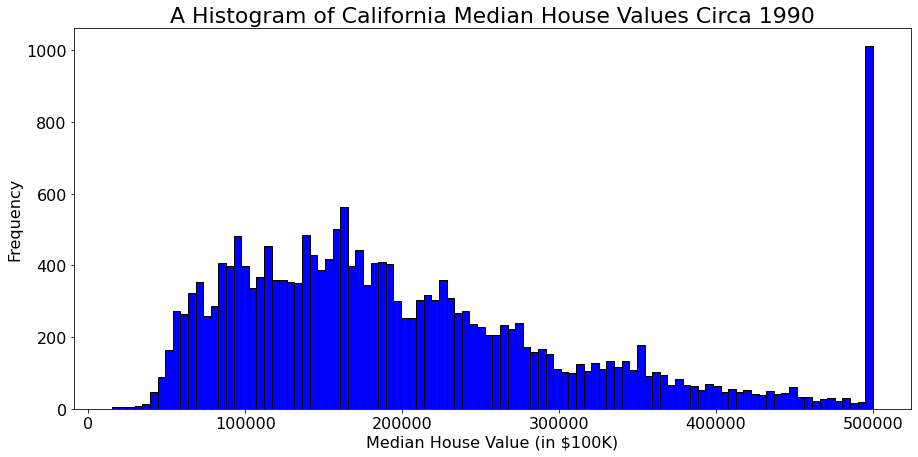

In [3]:
plt.figure(figsize=(15,7))
plt.hist(y, bins=100, color="blue", edgecolor="black")
plt.xlabel("Median House Value (in $100K)", size=16)
plt.ylabel("Frequency", size=16)
plt.title("A Histogram of California Median House Values Circa 1990", size=22)
plt.xticks(size=16)
plt.yticks(size=16)
plt.show()

In [4]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16512, 8) (16512,)
(4128, 8) (4128,)


In [5]:
# start timing
start_time = time.time()

# fit linear regression
my_linear_regression = LinearRegression().fit(X_train,y_train)
y_pred = my_linear_regression.predict(X_test)

end_time = time.time()

# print point estimates of the coefficients
print(f"beta_intercept: {round(my_linear_regression.intercept_, 2)}")
for i, col in enumerate(california.feature_names):
    print(f"beta_{col}: {round(my_linear_regression.coef_[i], 2)}")

beta_intercept: -3703777.05
beta_MedInc: 42891.77
beta_HouseAge: 982.71
beta_AveRooms: -9971.93
beta_AveBedrms: 60198.47
beta_Population: -0.34
beta_AveOccup: -340.78
beta_Latitude: -42395.85
beta_Longitude: -43628.59


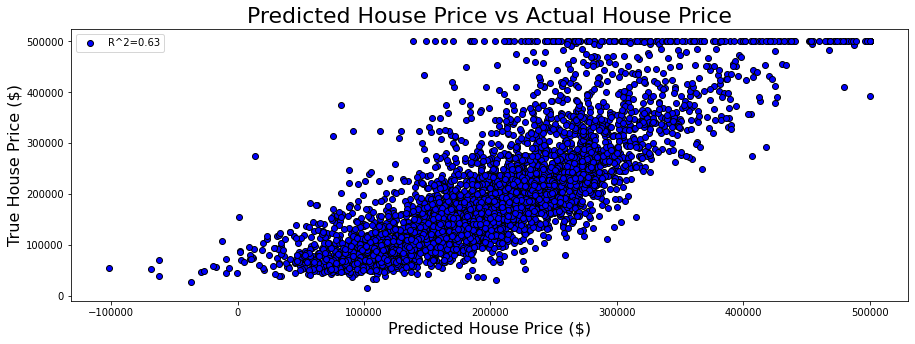

In [6]:
def plot_all_observations(y_true, y_pred, y_max):
    
    y_pred_censored = np.where(y_pred > y_max, y_max, y_pred)
    
    plt.figure(figsize=(15, 5))
    plt.scatter(y_pred_censored, y_test, 
                c="blue", edgecolor="black", 
                label=f'R^2={round(r2_score(y_test, y_pred_censored),2)}')
    
    plt.title("Predicted House Price vs Actual House Price", size=22)
    plt.xlabel("Predicted House Price ($)", size=16)
    plt.ylabel("True House Price ($)", size=16)
    plt.ticklabel_format(style='plain')
    plt.legend()
    
    plt.show()
    
    
    
# Now let's call our function
y_censor_label = y_train.max()
plot_all_observations(y_test, y_pred, y_censor_label)

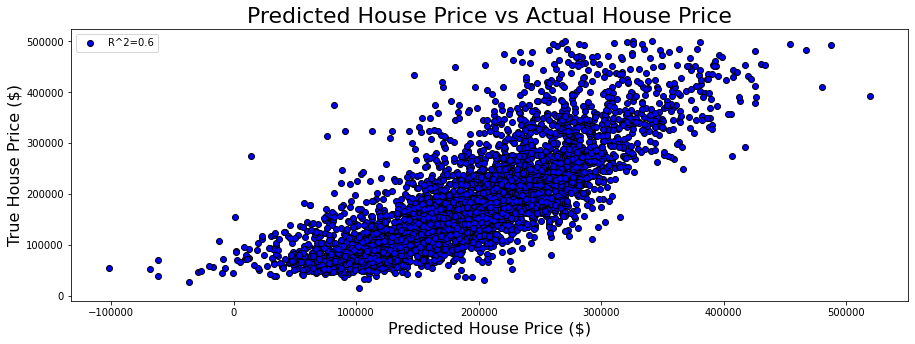

In [7]:
def plot_uncensored_observations(y_true, y_pred, y_censor_label):
    
    y_test_uncensored = y_test[y_test<y_censor_label]
    y_pred_uncensored = y_pred[y_test<y_censor_label]
    
    plt.figure(figsize=(15, 5))
    plt.scatter(y_pred_uncensored, y_test_uncensored, 
                c="blue", edgecolor="black", 
                label=f'R^2={round(r2_score(y_test_uncensored, y_pred_uncensored),2)}')
    
    plt.title("Predicted House Price vs Actual House Price", size=22)
    plt.xlabel("Predicted House Price ($)", size=16)
    plt.ylabel("True House Price ($)", size=16)
    plt.ticklabel_format(style='plain')
    plt.legend()
    
    plt.show()
    
    
    
# Now let's call our function
plot_uncensored_observations(y_test, y_pred, y_censor_label)

In [8]:
# import all required Pyro/Pytorch libraries
import torch
torch.set_default_tensor_type(torch.FloatTensor) # set the default to float32

import pyro
import pyro.distributions as dist

# We will use Markov Chain Monte Carlo (MCMC) methods here, specifically the No U-Turn Sampler (NUTS)
from pyro.infer import MCMC, NUTS

In [9]:
def model_normal(X, y, column_names):
    
    # Define our intercept prior
    intercept_prior = dist.Normal(0.0, 1.0)
    linear_combination = pyro.sample(f"beta_intercept", intercept_prior)
    
    
    # Also define coefficient priors
    for i in range(X.shape[1]):
        coefficient_prior = dist.Normal(0.0, 1.0)
        beta_coef = pyro.sample(f"beta_{column_names[i]}", coefficient_prior)
        linear_combination = linear_combination + (X[:, i] * beta_coef)
    
    
    # Define a sigma prior for the random error
    sigma = pyro.sample("sigma", dist.HalfNormal(scale=10.0))
    
    # For a simple linear model, the expected mean is the linear combination of parameters
    mean = linear_combination
    
    
    with pyro.plate("data", y.shape[0]):
        
        # Assume our expected mean comes from a normal distribution with the mean which
        # depends on the linear combination, and a standard deviatin "sigma"
        outcome_dist = dist.Normal(mean, sigma)
        
        # Condition the expected mean on the observed target y
        observation = pyro.sample("obs", outcome_dist, obs=y)

In [10]:
SAMPLE_NUMBER = 3000

# Turn out numpy data into PyTorch 
# tensors
X_train_torch = torch.tensor(X_train)
y_train_torch = torch.tensor(y_train)

# Clear the parameter storage
pyro.clear_param_store()

# Initialize our No U-Turn Sampler
my_kernel = NUTS(model_normal, 
                 max_tree_depth=7) # a shallower tree helps the algorithm run faster

# Employ the sampler in an MCMC sampling 
# algorithm, and sample 3100 samples. 
# Then discard the first 100
my_mcmc1 = MCMC(my_kernel,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)


# Let's time our execution as well
start_time = time.time()

# Run the sampler
my_mcmc1.run(X_train_torch, 
             y_train_torch,
             california.feature_names)

end_time = time.time()

print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

Sample: 100%|██████████| 3100/3100 [00:43, 72.01it/s, step size=5.81e-03, acc. prob=0.002]Inference ran for 0.72 minutes



In [11]:
my_mcmc1.summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_intercept     -1.83      0.00     -1.83     -1.83     -1.83      5.99      1.05
      beta_MedInc      0.57      0.00      0.57      0.57      0.57      5.09      1.26
    beta_HouseAge     -1.09      0.00     -1.09     -1.09     -1.09      2.93      1.94
    beta_AveRooms     -1.45      0.00     -1.45     -1.45     -1.45      3.02      1.84
   beta_AveBedrms      0.24      0.00      0.24      0.24      0.24      2.96      1.96
  beta_Population     19.82      1.46     20.55     17.06     21.22      3.12      1.81
    beta_AveOccup     -1.60      0.00     -1.60     -1.60     -1.60     12.92      1.00
    beta_Latitude     -1.84      0.00     -1.84     -1.84     -1.84      2.82      2.17
   beta_Longitude     -1.38      0.00     -1.38     -1.38     -1.38      4.15      1.48
            sigma  16568.23    112.77  16626.60  16402.79  16677.88      5.44      1.28

Number of divergences: 1601


In [12]:
beta_df = pd.DataFrame(my_mcmc1.get_samples())
beta_df.head()

beta_intercept  beta_MedInc  beta_HouseAge  beta_AveRooms  beta_AveBedrms  \
0       -1.826959     0.571893      -1.093132      -1.448368        0.241485   
1       -1.826959     0.571893      -1.093132      -1.448368        0.241485   
2       -1.826959     0.571893      -1.093132      -1.448368        0.241485   
3       -1.826959     0.571893      -1.093132      -1.448368        0.241485   
4       -1.826959     0.571893      -1.093132      -1.448368        0.241485   

   beta_Population  beta_AveOccup  beta_Latitude  beta_Longitude         sigma  
0        14.195314      -1.599754      -1.839666       -1.373381  16749.952228  
1        14.195314      -1.599754      -1.839666       -1.373381  16749.952228  
2        14.195314      -1.599754      -1.839666       -1.373381  16749.952228  
3        14.195314      -1.599754      -1.839666       -1.373381  16749.952228  
4        14.195314      -1.599754      -1.839666       -1.373381  16749.952228

In [13]:
def predict_linear_combination(beta_df, X):
    
    # Don't grab the last column, that is our estimate of the error standard deviation, "sigma"
    coefficients = beta_df.iloc[:, :-1].mean()
    print(coefficients.iloc[0], coefficients.shape)

    # Find our linear combination again
    linear_combination = X.dot(coefficients[1:]) + coefficients.iloc[0]
    
    return linear_combination

In [14]:
linear_combination = predict_linear_combination(beta_df, X_test)
# Our predictions are the linear combination
y_pred = linear_combination

-1.826931776948762 (9,)


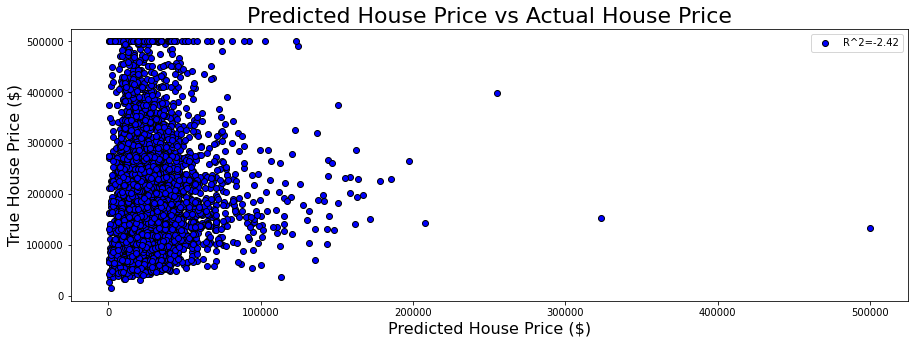

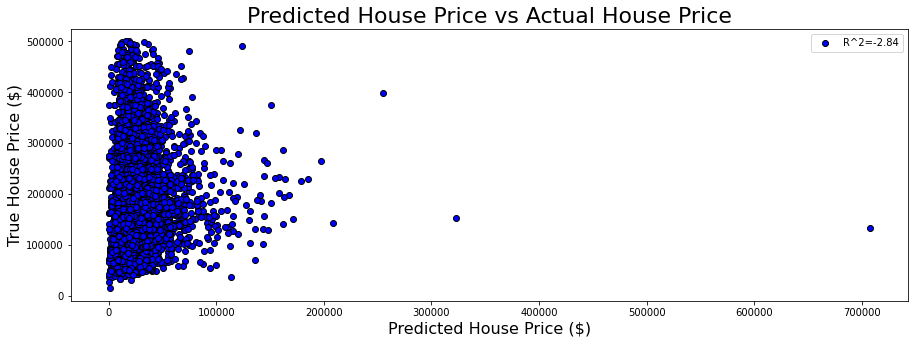

In [15]:
plot_all_observations(y_test, y_pred, y_censor_label)
plot_uncensored_observations(y_test, y_pred, y_censor_label)

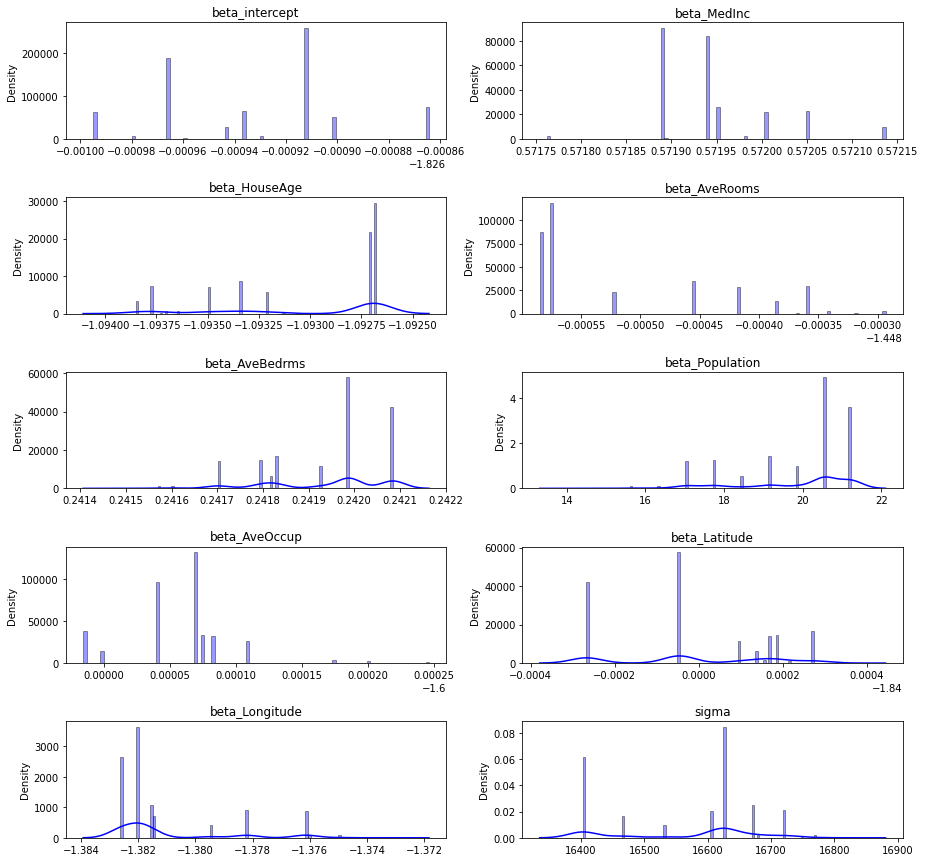

In [16]:
def draw_coefficients(beta_df):
    figure, axis = plt.subplots(5,2, figsize=(15,15))


    for key, ax in zip(beta_df.columns, axis.ravel()):
        ax.set_title(key)
        sns.distplot(beta_df[key], 
                     ax=ax, 
                     bins=100, 
                     color="blue", 
                     kde=True, 
                     axlabel=False, 
                     hist_kws=dict(edgecolor="black"))

    plt.subplots_adjust(hspace=0.5)
    plt.show()
    
draw_coefficients(beta_df)

In [17]:
from sklearn.preprocessing import StandardScaler


# Scale X
my_x_scaler = StandardScaler()
X_train_scaled = my_x_scaler.fit_transform(X_train)

# Scale y
y_censor_label = y_train.max()
y_train_scaled = y_train/y_censor_label

In [18]:
# Convert our data into pytorch tensors
X_train_torch = torch.tensor(X_train_scaled)
y_train_torch = torch.tensor(y_train_scaled)


# Clear previous parameters
pyro.clear_param_store()

# Perform inference again
my_kernel2 = NUTS(model_normal, max_tree_depth=7)

my_mcmc2 = MCMC(my_kernel2,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)


start_time = time.time()
my_mcmc2.run(X_train_torch,
             y_train_torch,
             california.feature_names)
end_time = time.time()

print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

Sample: 100%|██████████| 3100/3100 [08:25,  6.13it/s, step size=2.22e-03, acc. prob=0.884]Inference ran for 8.42 minutes



In [29]:
my_mcmc2.summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_intercept      0.41      0.00      0.41      0.41      0.42   3084.00      1.00
      beta_MedInc      0.16      0.00      0.16      0.16      0.17    744.65      1.00
    beta_HouseAge      0.02      0.00      0.02      0.02      0.03   2877.70      1.00
    beta_AveRooms     -0.05      0.00     -0.05     -0.06     -0.05    863.00      1.00
   beta_AveBedrms      0.06      0.00      0.06      0.05      0.06    923.03      1.00
  beta_Population     -0.00      0.00     -0.00     -0.00      0.00   3863.31      1.00
    beta_AveOccup     -0.01      0.00     -0.01     -0.01     -0.01   1414.74      1.00
    beta_Latitude     -0.18      0.00     -0.18     -0.19     -0.18   1322.78      1.00
   beta_Longitude     -0.17      0.00     -0.17     -0.18     -0.17   1360.69      1.00
            sigma      0.15      0.00      0.15      0.14      0.15   3248.99      1.00

Number of divergences: 0


In [34]:
def create_beta_df(beta_df, x_scaler, feature_names):        
    
    i = 0
    # for each column except the intercept and the additional sigma term
    for col in beta_df:
        if (col != 'beta_intercept'):
            if ('beta_' in col):
                print(i, col, x_scaler.mean_[i], x_scaler.scale_[i])

                # subtract the appropriate value from the intercept (review intercept final expression)
                beta_df['beta_intercept'] -= (beta_df[col] * x_scaler.mean_[i])/x_scaler.scale_[i]     
                
                # scale the coefficient (review each coefficient final expression)
                beta_df[col] /= x_scaler.scale_[i]
                i += 1

    return beta_df

In [35]:
beta2_df = pd.DataFrame(my_mcmc2.get_samples())
beta2_df = create_beta_df(beta2_df, my_x_scaler, california.feature_names)

beta2_df *= y_censor_label   # multiply everything by y_max outside the function for reasons that will
                             # become clear later

0 beta_MedInc 3.8694272044573803 1.9008296706444527
1 beta_HouseAge 28.640564437984494 12.588547204047673
2 beta_AveRooms 5.42888164325174 2.5587944140641334
3 beta_AveBedrms 1.0969207121976432 0.4955842927018272
4 beta_Population 1421.647710755814 1107.7107156374946
5 beta_AveOccup 3.1019951311509097 11.601903548308085
6 beta_Latitude 35.63062742248063 2.136108747273474
7 beta_Longitude -119.56613917151134 2.0007858674687617


In [36]:
pd.DataFrame({ c: beta2_df[c] for c in sorted(beta2_df.columns)}).head(5)
beta2_df.head()

beta_intercept   beta_MedInc  beta_HouseAge  beta_AveRooms  beta_AveBedrms  \
0   -3.865114e+06  42688.077917     950.609968   -9267.164139    57455.045980   
1   -3.740897e+06  42489.355936     962.035759   -9404.980268    58090.082727   
2   -3.687373e+06  42602.400897    1005.966449   -9537.808826    58986.877204   
3   -3.773540e+06  42530.135880     940.040970   -9734.424078    58922.594690   
4   -3.693390e+06  42470.220620     989.580463   -9771.518234    58914.173195   

   beta_Population  beta_AveOccup  beta_Latitude  beta_Longitude         sigma  
0        -0.573048    -371.414055  -43619.663426   -45356.155458  72683.997785  
1        -0.643773    -362.423260  -43513.906035   -44283.196136  72363.514949  
2        -0.605264    -357.712480  -42479.632212   -43506.939899  72673.088717  
3        -0.377241    -323.442465  -43011.647536   -44425.255869  73448.029816  
4         0.012197    -319.818059  -42303.047308   -43520.849008  72156.417116

-3703048.7485434865 (9,)
[[ 4.17500000e+00  1.40000000e+01  5.60469867e+00  1.04596527e+00
   2.82300000e+03  2.88355465e+00  3.71400000e+01 -1.21640000e+02]
 [ 3.65910000e+00  5.20000000e+01  4.93190661e+00  9.51361868e-01
   1.09400000e+03  2.12840467e+00  3.78400000e+01 -1.22250000e+02]
 [ 2.95450000e+00  4.70000000e+01  5.63224181e+00  1.05289673e+00
   1.04200000e+03  2.62468514e+00  3.67500000e+01 -1.19740000e+02]]
[229800. 299200.  59600.]
[226578.59712919 240639.60304632 141206.63045177]
500000.99999999994


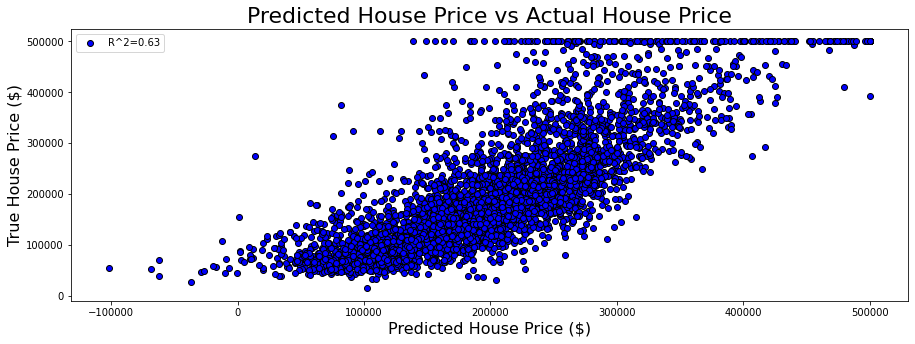

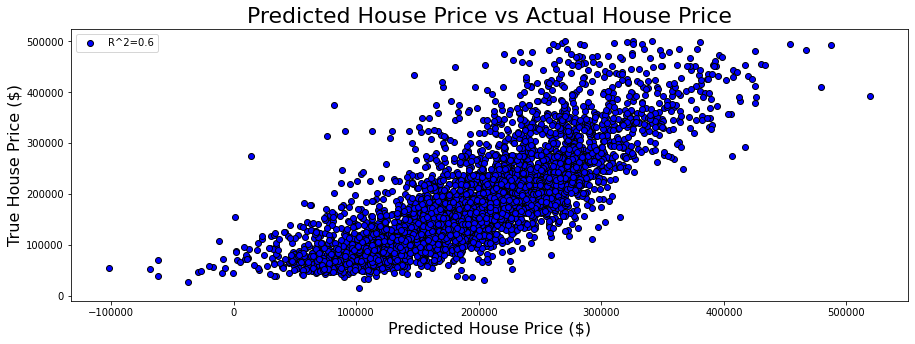

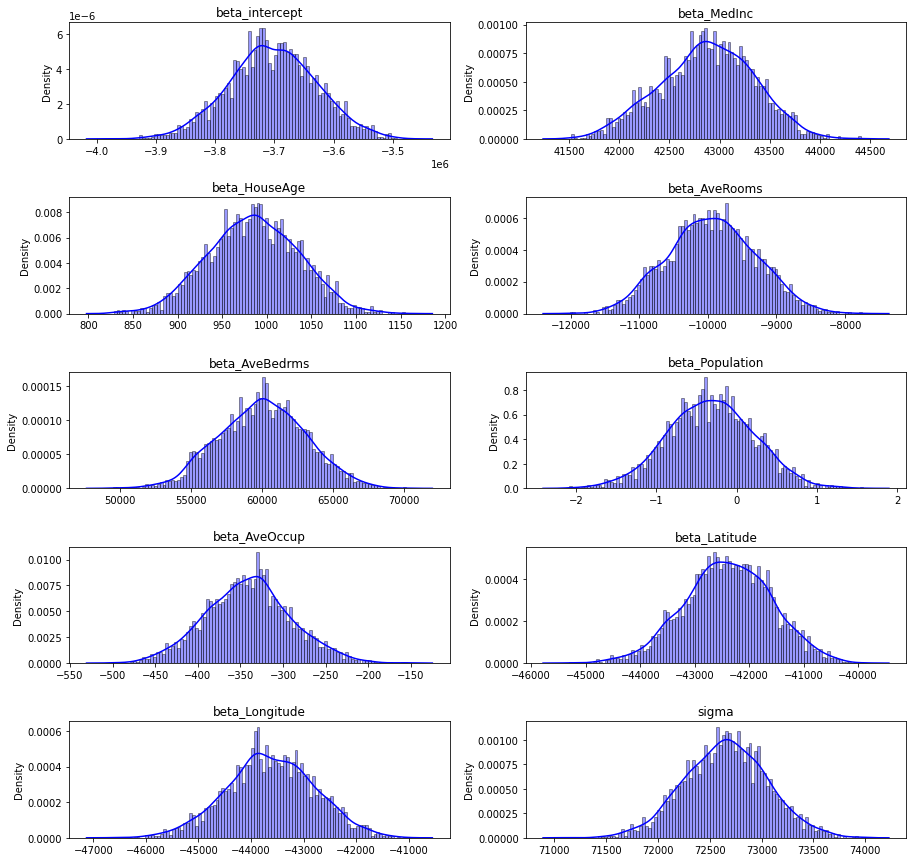

In [23]:
linear_combination = predict_linear_combination(beta2_df, X_test)

y_pred = linear_combination
print(X_test[:3,:])
print(y_test[:3])
print(y_pred[:3])
print(y_censor_label)

plot_all_observations(y_test, y_pred, y_censor_label)
plot_uncensored_observations(y_test, y_pred, y_censor_label)

draw_coefficients(beta2_df)

In [26]:
def model_gamma(X, y, column_names):
    pyro.enable_validation(True)
    
    min_value = torch.finfo(X.dtype).eps
    max_value = torch.finfo(X.dtype).max
    
    # We still need to calculate our linear combination
    
    intercept_prior = dist.Normal(0.0, 1.0)
    linear_combination = pyro.sample(f"beta_intercept", intercept_prior)
    
    
    # Also define coefficient priors
    for i in range(X.shape[1]):
        coefficient_prior = dist.Normal(0.0, 1.0)
        beta_coef = pyro.sample(f"beta_{column_names[i]}", coefficient_prior)
        
        linear_combination = linear_combination + (X[:, i] * beta_coef)
    
        
    # But now our mean will be e^{linear combination}    
    mean = torch.exp(linear_combination).clamp(min=min_value, max=max_value)
    
    # We will also define a rate parameter
    rate = pyro.sample("rate", dist.HalfNormal(scale=10.0)).clamp(min=min_value)
    
    # Since mean = shape/rate, then the shape = mean * rate
    shape = (mean * rate)
    
    
    
    # Now that we have the shape and rate parameters for the
    # Gamma distribution, we can draw samples from it and condition
    # them on our observations
    with pyro.plate("data", y.shape[0]):
        
        outcome_dist = dist.Gamma(shape, rate)
        
        observation = pyro.sample("obs", outcome_dist, obs=y)

In [37]:
# Clear all previous runs of pyro
pyro.clear_param_store()

# And again, perform inference
my_kernel3 = NUTS(model_gamma, max_tree_depth=7)


my_mcmc3 = MCMC(my_kernel3,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)



start_time = time.time()
my_mcmc3.run(X_train_torch,
             y_train_torch,
             california.feature_names)
end_time = time.time()

print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

Sample: 100%|██████████| 3100/3100 [36:01,  1.43it/s, step size=1.40e-02, acc. prob=0.685]Inference ran for 36.03 minutes



In [ ]:
my_mcmc3.summary()

In [ ]:
beta3_df = pd.DataFrame(my_mcmc3.get_samples())
beta3_df = create_beta_df(beta3_df, my_x_scaler, california.feature_names)

# Notice now we have to use the y_max value slightly differently
beta3_df['beta_intercept'] += np.log(y_censor_label)

In [ ]:
linear_combination = predict_linear_combination(beta3_df, X_test)

# We have to take the EXP of the linear combination now to get the expected values
y_pred = np.exp(linear_combination)

plot_all_observations(y_test, y_pred, y_censor_label)
plot_uncensored_observations(y_test, y_pred, y_censor_label)

draw_coefficients(beta3_df)